# Logistic MSE Classifier

In this notebook we will learn how to code up a logistic MSE from scratch.

In [2]:
# Import all required libraries
from __future__ import division # For python 2.*

import numpy as np
import matplotlib.pyplot as plt
import mltools as ml

np.random.seed(0)
%matplotlib inline

## Loading the Data
We will use the same data set from the previous discussion. Because we are going to use the sigmoid function this time we will use 0 and 1 as classes.

C:\Users\dheer\Documents\workspace\ml-discussions\week4\mltools\plot.py:42: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  hld = axis.ishold();
C:\Users\dheer\Documents\workspace\ml-discussions\week4\mltools\plot.py:43: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  axis.hold(True);
c:\users\dheer\python3.6\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\dheer\python3.6\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be rem

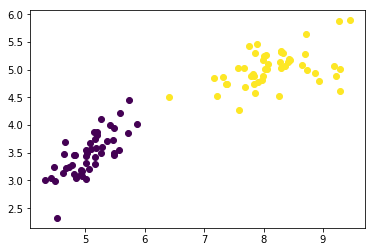

In [4]:
lc2_data = np.genfromtxt('data/lc2_data.txt', delimiter=None)
X, Y = lc2_data[:, :-1], lc2_data[:, -1]

Y[np.where(Y == -1)[0]] = 0
ml.plotClassify2D(None, X, Y)

## Logistic MSE Objective/Cost Function
The objective function for the Logistic MSE is: $$J(\theta) = \frac{1}{m}\sum_i (\sigma(\theta x^i) - y^i)^2$$

So let's code it up.

In [5]:
def add_const(X):
    """Adding constant intercept to data. """
    return np.hstack([np.ones([X.shape[0], 1]), X])

def sigmoid(z):
    """Sigmoid function. """
    return 1. / (1 + np.exp(-z))

def response(x, theta):
    """Inner product of theta x"""
    return np.dot(x, theta)

def sig_pred(x, theta):
    """Returns the class according to the threshold 0.5"""
    f_vals = sigmoid(response(x, theta))
    f_vals[f_vals >= .5] = 1
    f_vals[f_vals < .5] = 0

    return f_vals

def mse_err(x, y, theta):
    """Calculates MSE for Logistic Classifier. """
    return np.mean((sigmoid(response(x, theta)) - y)**2)

Let's take it for a spin

In [8]:
Xconst = add_const(X)
theta = [5., 1., 1.]
print(mse_err(Xconst, Y, theta))

0.499998308481


## Training the Model

Given paremters $\theta$ and a cost function $J(\theta)$, the gradient descent update is:

$$\theta = \theta - \alpha \nabla_{\theta} J (\theta)$$

So all we need is to learn how to do $$\nabla_{\theta} J (\theta)$$

From the classes slides we already know that:

$$\partial J (\theta) = \frac{1}{m} \sum_i 2(\sigma(\theta x^i) - y^i) \; \partial \sigma(\theta x^i) \; x^i$$ 

and that $$\partial \sigma(z) = \sigma(z) (1 - \sigma(z))$$

Gradient calculation step by step

In [14]:
error = sigmoid(response(Xconst, theta)) - Y

In [15]:
sig_resp = sigmoid(response(Xconst, theta))
der_sigmoid = sig_resp * (1 - sig_resp)

In [19]:
tmp = error * der_sigmoid

In [20]:
grad_vals = np.reshape(tmp, [-1, 1]) * Xconst 

In [21]:
grad_vals.shape

(98, 3)

In [23]:
gradient = np.mean(grad_vals, axis=0)
# Notice that I ignored the 2. It's totally ok to do that.

## Important note: Your gradient needs to be in the shape of the parameters. So in this case 3 features of the theta

In [24]:
gradient

array([  8.45756408e-07,   4.09379546e-06,   2.73010603e-06])

In [30]:
def mse_grad(Xconst, Y, theta):
    """Calculates the Logistic MSE Gradient. """
    f_val = sigmoid(response(Xconst, theta))
    error = f_val - Y
    der_sigmoid = f_val * (1 - f_val)
    
    grad_vals =  np.reshape(error * der_sigmoid, [-1, 1]) * Xconst 
    
    return np.mean(grad_vals, axis=0)

In [31]:
print(mse_grad(Xconst, Y, theta))

[  8.45756408e-07   4.09379546e-06   2.73010603e-06]


## Train Function

In [35]:
def train(X, Y, theta, a=0.05, tol=1e-3, max_iters=100):
    """Trains the model and returns an array with the error at each iteration. """
    # In this version we assume we get the regular X as an input
    Xconst = add_const(X)
    
    J_err = [np.inf]
    for i in range(max_iters):
        # Updating the theta
        theta -= a * mse_grad(Xconst, Y, theta)
        
        # Computing the new error
        error = mse_err(Xconst, Y, theta)
        J_err.append(error)
        
        # Checking for stopping conditions. Notice that this time I'm forcing at least
        # 10 iterations.
        if i > 10 and np.abs(J_err[-2] - J_err[-1]) < tol:
            break
        
    return theta, J_err 

In [36]:
theta = np.array([-5., 1., 0.])
_, err = train(X, Y, theta)

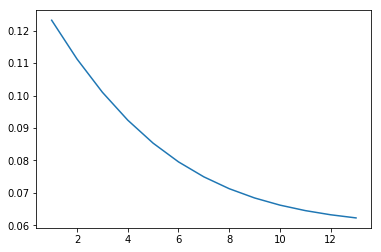

In [37]:
plt.plot(err)

In [44]:
from mltools.base import classifier
class LogisticMSE(classifier):
    def __init__(self, theta=None):
        self.theta = theta

    def add_const(self, X):
        return np.hstack([np.ones([X.shape[0], 1]), X])        
        
    # Main functions
    def sigmoid(self, x):
        return 1. / (1 + np.exp(-x))    

    def response(self, x):
        return np.dot(x, self.theta)
    
    def sig_pred(self, x):
        f_vals = self.sigmoid(self.response(x))
        f_vals[f_vals >= .5] = 1
        f_vals[f_vals < .5] = 0

        return f_vals    
    
    def predict(self, X):
        Xconst = np.atleast_2d(X)
        if Xconst.shape[1] == self.theta.shape[0] - 1:
            Xconst = self.add_const(Xconst)
        
        return self.sig_pred(Xconst)

    def mse_err(self, x, y):
        """Calculate mse error for logistic regression. """
        return np.mean((self.sigmoid(self.response(x)) - y)**2)    
    
    def mse_grad(self, Xconst, Y):
        """Calculate gradient of loss/cost for logistic MSE. """
        f_val = self.sigmoid(self.response(Xconst))
        error = f_val - Y
        der_sigmoid = f_val * ( 1 - f_val )

        tmp = error * der_sigmoid
        derivative_sum = np.reshape(tmp, [-1, 1]) * Xconst

        return np.mean(derivative_sum, axis=0)    
    
    def train(self, X, Y, a=0.01, tol=1e-3, max_iters=100):
        """Trains the model and returns an array with the error at each iteration. """
        # In this version we assume we get the regular X as an input
        Xconst = self.add_const(X)
        if self.theta is None:
            print('Initializing theta')
            self.theta = Xconst[5]
#             self.theta = np.random.rand(Xconst.shape[1])        
        
        J_err = [np.inf]
        for i in range(max_iters):
            # Updating the theta
            self.theta -= a * self.mse_grad(Xconst, Y)
            
            # Computing the new error
            error = self.mse_err(Xconst, Y)
            J_err.append(error)
            
            # Checking for stopping conditions. Notice that this time I'm forcing at least
            # 10 iterations.
            if i > 10 and np.abs(J_err[-2] - J_err[-1]) < tol:
                break
        
        print("Error at end of iteration {0} is {1}".format(i, J_err[-1]))   
        return J_err

C:\Users\dheer\Documents\workspace\ml-discussions\week4\mltools\plot.py:42: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  hld = axis.ishold();
C:\Users\dheer\Documents\workspace\ml-discussions\week4\mltools\plot.py:43: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  axis.hold(True);
c:\users\dheer\python3.6\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\dheer\python3.6\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be rem

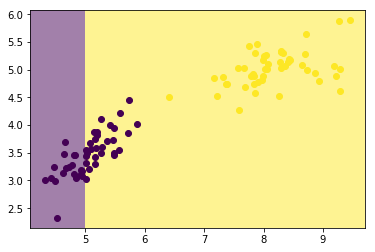

In [45]:
lc = LogisticMSE(theta=np.array([-5., 1., 0.]))
ml.plotClassify2D(lc, X, Y)

Error at end of iteration 11 is 0.059522864152493894


C:\Users\dheer\Documents\workspace\ml-discussions\week4\mltools\plot.py:42: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  hld = axis.ishold();
C:\Users\dheer\Documents\workspace\ml-discussions\week4\mltools\plot.py:43: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  axis.hold(True);
c:\users\dheer\python3.6\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\dheer\python3.6\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be rem

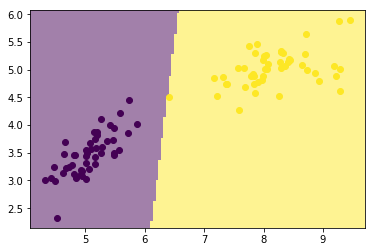

In [46]:
J_err = lc.train(X, Y, a=0.1, max_iters=100)
ml.plotClassify2D(lc, X, Y)

## Interactive Plotting
For those of you who are going to run the code from a notebook and want to still see an interactive plotting you'll have to change the code a little bit. 

The simplest way to do it is to use the IPython disply in the following way.

In [ ]:
from IPython import display
for i in range(2, len(J_err)):
    plt.figure(1)
    plt.plot(J_err[:i], 'k-', lw=3)
    plt.draw()
    
    # Waiting on either an input or time sleep.
    _ = raw_input()
    
    # Just add this to the original code where you think it should go :)
    display.clear_output()
    display.display(plt.gcf())    